<a href="https://colab.research.google.com/github/sclaudiobr/algoritmos-py/blob/master/Geocloud01_Altimetria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Geo Cloud - Dados do IBGE e Altimetria
<p> Neste tutorial vamos conhecer uma ferramenta para busca de dados nos repositórios da internet onde a tarefa é selecionar uma área correspondente a abrangência dos limites de um município da base de dados do IBGE e recortar o quadrante sobre os dados do modelo de digital de elevação (MDE 30 metros) disponível na base de dados da USGS.<p>


In [ ]:
# BIBLIOTECAS EXTERNAS NECESSÁRIAS
!pip install geobr # Base de dados do IBGE, Malahas municipais, biomas, microrregiões, sedes
!pip install elevation # Base de dados de elevação
!pip install richdem # Ferramenta de processamento de dados de elevação
!pip install rasterio

In [4]:
# IMPORTANDO AS BIBLIOTECAS
import geobr as br
import geopandas as gpd
import os
import numpy as np
from osgeo import gdal
import elevation as mde
import richdem as rd
from shapely.geometry import Polygon
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!eio selfcheck
!mkdir proj
!mkdir proj/shp
!mkdir proj/raster
#!rm -r proj

Your system is ready.


/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


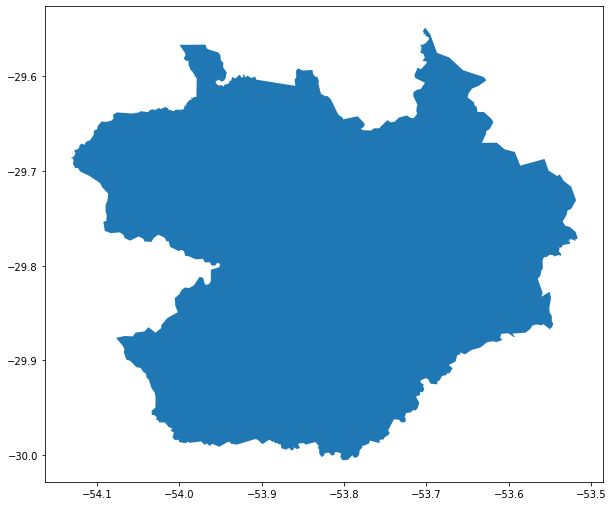

In [5]:
# ACESSANDO OS DADOS DENTRO DO REPOSITÓRIO GEOBR
df = br.read_municipality(code_muni='RS')
df = df[df.name_muni=='Santa Maria']
df = df.to_crs(crs='EPSG:4326')
# Gerando o polígono do retângulo da área abrangente
ax = df.plot(figsize=(10,10))
dfbox = box(*df.total_bounds).bounds
latitude,longitude = np.array(dfbox)[1],np.array(dfbox)[2]
df.to_file('./proj/shp/df.shp', driver='ESRI Shapefile')

# ALTIMETRIA

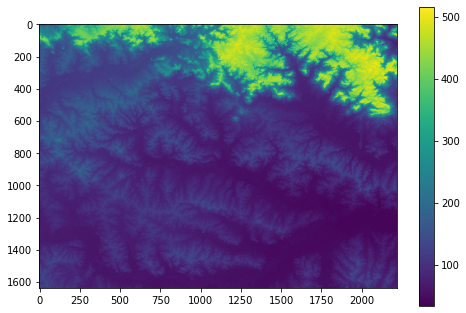

In [6]:
mde.clip(bounds= dfbox, output='/content/proj/raster/sm.tif')
matplotlib.rcParams['figure.figsize'] = (8, 5.5)
dem_path = os.path.join(os.getcwd(), 'proj/raster/sm.tif')
dem = rd.LoadGDAL(dem_path)
fill = rd.FillDepressions(dem, epsilon=False, in_place=False, topology='D8')
beau_breached = rd.BreachDepressions(fill, in_place=False)
rd.SaveGDAL('proj/raster/fill_dem.tif',beau_breached)
plt.imshow(beau_breached, interpolation='none')
plt.colorbar()
plt.show()

In [7]:
import fiona
import rasterio
import rasterio.mask

with fiona.open("proj/shp/df.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open("proj/raster/fill_dem.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("proj/raster/masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

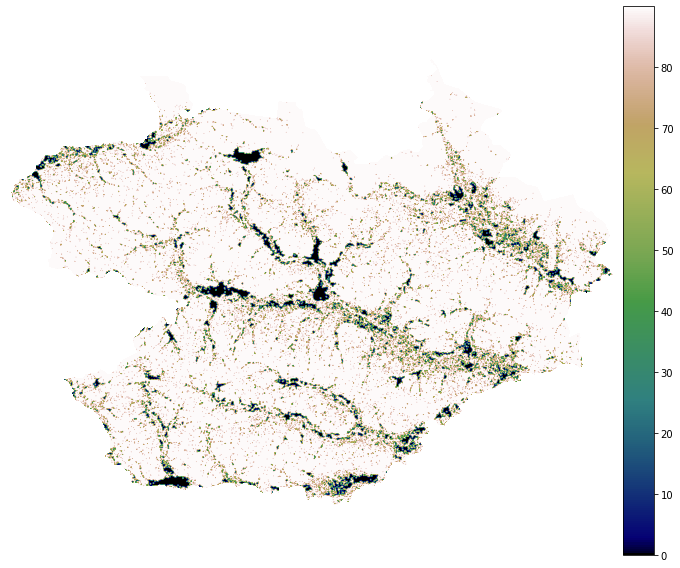

In [11]:
fdem = rd.LoadGDAL('proj/raster/masked.tif')
slope = rd.TerrainAttribute(fdem, attrib='slope_degrees')
rd.rdShow(slope, axes=False, cmap='gist_earth', figsize=(10, 8))
plt.show()
rd.SaveGDAL('proj/raster/slope.tif' , slope)

In [ ]:
aspect = rd.TerrainAttribute(fdem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(10,8))
plt.show()
rd.SaveGDAL('proj/raster/aspect.tif' , aspect)

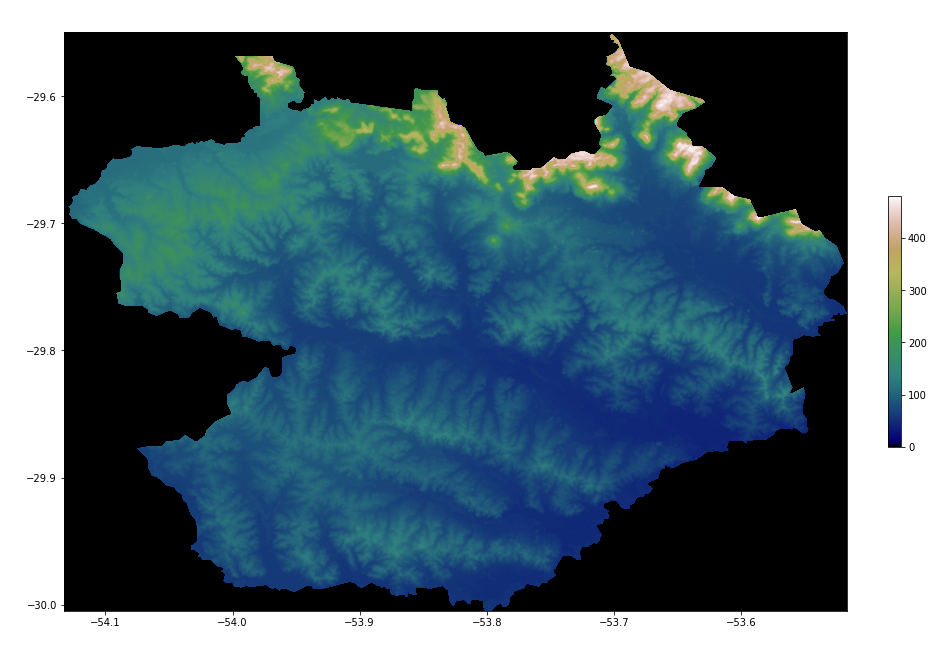

In [16]:

#dataset = gdal.Open('/content/sample_data/sm.tif', gdal.GA_ReadOnly)
GDAL = gdal.Open('proj/raster/sm.tif', gdal.GA_ReadOnly)
data = GDAL.ReadAsArray()

# Processo necessário para reprojetar de volta
projection = GDAL.GetProjection() # <- pega aprojeção
geotransform = GDAL.GetGeoTransform()# <- Associa as coordenadas
originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform # <-- faz a conversão de projeção
cols =  GDAL.RasterXSize # <-- guarda valores do eixo X
rows =  GDAL.RasterYSize # <-- guarda valores do eixo Y
finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows
extentArray = [originX,finalX,originY,finalY]

# ----- Plotando os dados com coordenadas
def plotRaster(rasterImage,extentArray,vmin,cmap):
    raster = gdal.Open(rasterImage)
    dsraster = raster.ReadAsArray()
    plt.figure(figsize=(15,15))
    im = plt.imshow(dsraster, vmin=vmin, cmap=cmap, extent=extentArray)#
    plt.colorbar(im, fraction=0.015)
    plt.title('Mapa de Declividade',size=25, color='white')
    plt.xlabel('Longitude', size=15,color='white')
    plt.ylabel('Latitude', size=15,color='white',  rotation=90)
    plt.autoscale(enable=True,axis='both')   
    plt.show()
plotRaster('proj/raster/masked.tif',extentArray,0,'gist_earth')

In [17]:
# Comprimindo a pasta do projeto
import zipfile
import os
fantasy_zip = zipfile.ZipFile('projeto.zip', 'w')
for folder, subfolders, files in os.walk('./proj/'):
    for file in files:
        fantasy_zip.write(os.path.join(folder, file), file, compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.close()